## Home Assignmed 

Preformed by: Maxim Grinin

### Initial Setup

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import geopandas as gpd
from shapely.geometry import Polygon, Point

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import contextily
import mapclassify

from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score 

pd.set_option('display.max_columns', 50)
sns.set_style('whitegrid')

Прочитаем главный файл и удалим нерелевантную информацию 

In [3]:
# Read main file
df = gpd.read_file('spb.sale2.gpkg')
print(df.shape)
df.head(3)

(10627, 45)


,old_id,street.name_ru,house_number,microdistrict.name_ru,district.name_ru,city.name_ru,region.name_ru,price,price_per_sqm,rooms_count,floor,housing_estate,total_area,living_area,kitchen_area,type.title,wc_type.title,condition_type.title,house_type,reference_point,has_rubbish_chute,balcony_count,floors_count,has_phone,built_year,released,is_haggle,window_view,is_newbuilding,description,layout_type.value,porches_count,lat,lon,is_agency,is_active,deal_type,creation_date,modification_date,house_id,rubric,_id,release_date.year,house_material_type.valuereleased,geometry
0,309241222,Наставников проспект,21,None,None,Санкт-Петербург,Санкт-Петербург,4200000,110526,1,13,None,3800.0,2000.0,1000.0,None,раздельный,None,None,None,None,1,16,1,None,1,1,None,False,"Уютная, светлая квартира!\nРядом остановка ско...",None,None,59.946126,30.492171,True,True,sell,2020-03-26T10:44:12+00:00,2020-04-20T16:09:50+00:00,1167896.0,flats,33231779,NaN,None,POINT (30.49217 59.94613)
1,307093082,Тореза проспект,77 корп. 1,None,Выборгский район,Санкт-Петербург,Санкт-Петербург,19390000,138204,3,2,None,14030.0,6980.0,2335.0,None,несколько,None,None,None,None,0,5,None,None,1,None,None,False,Арт. 27512988 Вашему вниманию предлагается про...,separated,None,60.023488,30.327986,True,True,sell,2020-01-27T23:13:22+00:00,2020-04-20T23:08:56+00:00,1413945.0,flats,32802019,NaN,None,POINT (30.32799 60.02349)
2,309205812,Юрия Гагарина проспект,38 корп. 1,None,None,Санкт-Петербург,Санкт-Петербург,4605000,99032,2,1,None,4650.0,3030.0,600.0,None,раздельный,None,None,None,None,1,5,1,None,1,0,None,False,Продается Двухкомнатная квартира в Московском ...,None,None,59.841875,30.339125,True,True,sell,2020-03-26T10:39:35+00:00,2020-04-20T16:07:26+00:00,1355693.0,flats,33228193,NaN,None,POINT (30.33912 59.84188)


В файле присутствуют данные не по СПб и Лен. области, удалим эти данные, задав примерную зону релевантных значений.

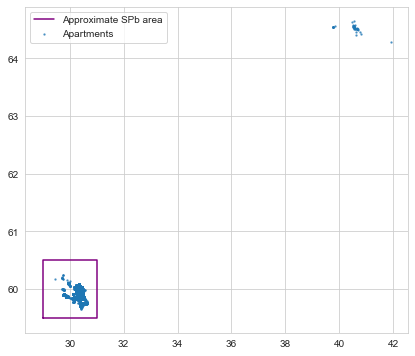

In [14]:
# Defining approximate are of APb region
spb_poly = Polygon([[29, 59.5], [31, 59.5], [31, 60.5], [29, 60.5]])
x, y = spb_poly.exterior.xy

# Plotting data
ax = df.plot(markersize = 2, alpha = 0.6, figsize = (8, 6), label = 'Apartments')
plt.plot(x, y, color = 'Purple', label = 'Approximate SPb area')
plt.legend()
plt.show()

Проверяем

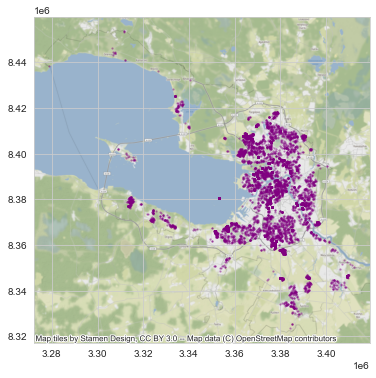

(10581, 45)


In [15]:
# Extract needed data from raw dataframe
data = df[df['geometry'].within(spb_poly)].copy().to_crs(epsg = 3857)
ax = data.plot(markersize = 2, color = 'purple', alpha = 0.3, figsize = (8, 6))
contextily.add_basemap(ax)
plt.show()

print(data.shape)

### Outliars & Anomalies

Посмотрим на карту с нанесенными на нее квартирами. Мы можем сразу заметить аномалии - квартиры на воде (зона выделена голубым).

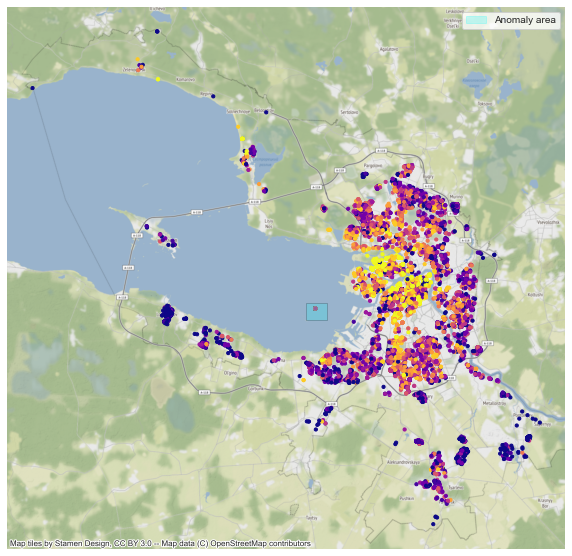

In [16]:
# Anomaly area
anom_poly_naive = Polygon([[30.1, 59.9], [30.15, 59.9], [30.15, 59.92], [30.1, 59.92]])
anom_poly = gpd.GeoSeries(anom_poly_naive, crs = 'WGS 84').to_crs(epsg = 3857)

# Plotting Data 
fig, ax = plt.subplots(figsize = (10, 10))
# Plotting apartments. Color based on its quantile (k=10)
data.plot(ax = ax,
          column = 'price_per_sqm', 
          scheme = 'quantiles',
          k = 10, 
          cmap = 'plasma',  
          legend = True,
          markersize = 10)

# Plotting anomaly area
anom_poly.plot(ax = ax, alpha = 0.2, color = 'aqua', edgecolors = 'black')
# Adding legend 
a_patch = mpatches.Patch(color = 'aqua', alpha = 0.2, label='Anomaly area')
ax.legend(handles = [a_patch])

# Adding layer with map 
contextily.add_basemap(ax)

ax.set_axis_off()
plt.show()

# Dropping Anomaly
data.drop(df[df['geometry'].within(anom_poly_naive)].index, inplace = True)

Карта после удаления аномалий.

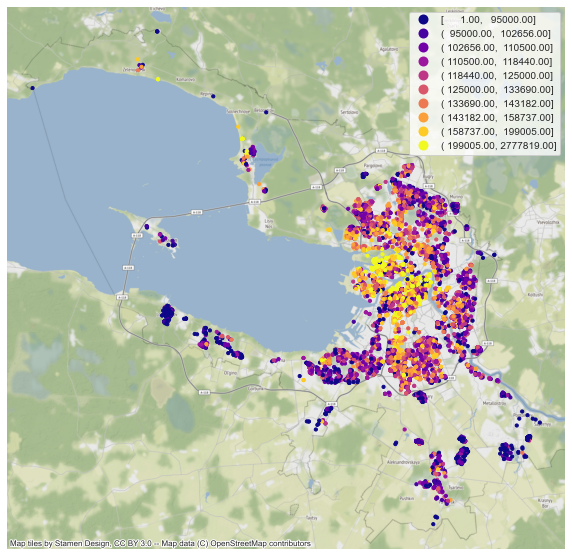

In [6]:
# Plotting Data 
fig, ax = plt.subplots(figsize = (10, 10))
# Plotting apartments. Color based on its quantile (k=10)
data.plot(ax = ax,
          column = 'price_per_sqm', 
          scheme = 'quantiles',
          k = 10, 
          cmap = 'plasma',  
          legend = True,
          markersize = 10)

# Adding layer with map 
contextily.add_basemap(ax)
ax.set_axis_off()
plt.show()

Посмотрим на описателные статистики и распределние цены на квадратный метр

count      10461.0
mean      139729.0
std        67969.0
min            1.0
25%       106509.0
50%       125000.0
75%       150000.0
max      2777819.0
Name: price_per_sqm, dtype: float64


<AxesSubplot:xlabel='price_per_sqm', ylabel='Density'>

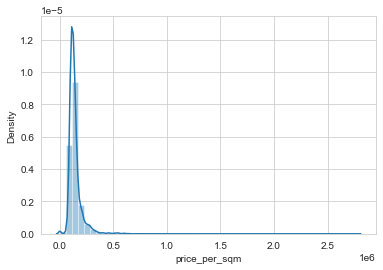

In [7]:
print(data['price_per_sqm'].describe().round())
sns.distplot(data['price_per_sqm'])

Как мы можем видеть, в данных присутствуют выбросы и очевидные аномалии. Согласно здравому смыслу и данным из гугла, квадратный метр в Санкт-Петербурге и Ленинградской Области вряд ли может стоить менее 36к рублей или более 1 миллиона. 
##### Удалим аномальные наблюдения из датасета

In [8]:
data.drop(data[data['price_per_sqm']>=1.1*10**6].index, inplace = True)
data.drop(data[data['price_per_sqm']<36*10**3].index, inplace = True)

Взглянем на описательные статистики и распределение еще раз 

count      10410.0
mean      140011.0
std        61113.0
min        37209.0
25%       106909.0
50%       125000.0
75%       150089.0
max      1000000.0
Name: price_per_sqm, dtype: float64


<AxesSubplot:xlabel='price_per_sqm', ylabel='Density'>

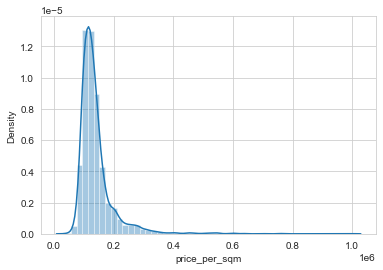

In [9]:
print(data['price_per_sqm'].describe().round())
sns.distplot(data['price_per_sqm'])

Посмотрим на описателные статистики и распределние общей площади квартиры

count    10404.0
mean      6135.0
std       4037.0
min       1100.0
25%       3710.0
50%       5100.0
75%       7119.0
max      53890.0
Name: total_area, dtype: float64


<AxesSubplot:xlabel='total_area', ylabel='Density'>

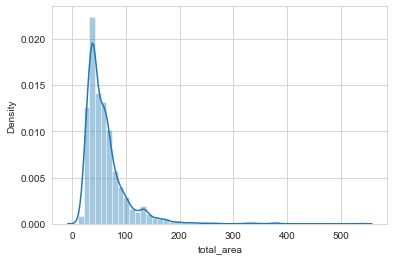

In [27]:
print(data['total_area'].describe().round())
sns.distplot(data['total_area'] / 100)

Здравый смысл так же подсказывает, что многих квартир с площадями представленными в датасете, не может существовать в реальности. Согласно данным ЦИАН, площадь самой большой квартры в Санкт-Петербурге равняется 539 кв. м. 

source: https://lenta.ru/news/2019/08/15/spb/

##### Удалим аномалии

count    104.04
mean      61.35
std       40.37
min       11.00
25%       37.10
50%       51.00
75%       71.19
max      538.90
Name: total_area, dtype: float64


<AxesSubplot:xlabel='total_area', ylabel='Density'>

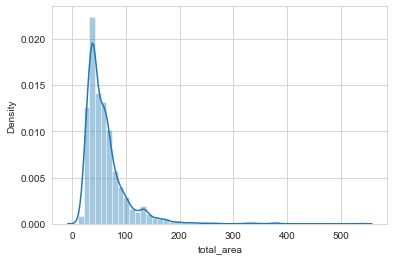

In [32]:
data.drop(data[data['total_area'] / 100 >= 539].index, inplace = True)

print(data['total_area'].describe().round() / 100)
sns.distplot(data['total_area'] / 100)

count     9630.0
mean      1361.0
std        934.0
min        100.0
25%        870.0
50%       1150.0
75%       1580.0
max      16880.0
Name: kitchen_area, dtype: float64


<AxesSubplot:xlabel='kitchen_area', ylabel='Density'>

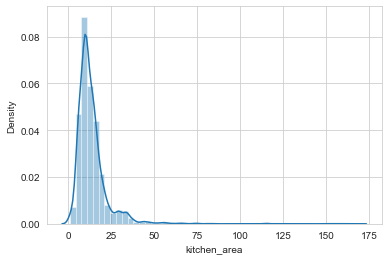

In [28]:
print(data['kitchen_area'].describe().round())
sns.distplot(data['kitchen_area'] / 100)

### Preprocessing

#### Missing Values 

Удалим полностью пустые колонки 

In [12]:
# Dropping completely null columns
cols_to_drop = data.columns[data.isna().all()].tolist()
data.drop(cols_to_drop, axis = 1, inplace = True)

Посчитаем процент пропущенных значений в каждой из колонок, где эти пропущенные значения имеются

In [13]:
def missing_values_table(df):
    
        '''Calculate percent of missing values 
         in each column of passed DataFrame'''
        
        # Total missing values
        mis_val = df.isna().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isna().sum() / len(df)

        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Пропущенных значений', 1 : '% от общего количества значений'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% от общего количества значений', ascending=False).round(1)
        
        # Print some summary information
        print ("В датасете " + str(df.shape[1]) + " колонок.\n" +      
              str(mis_val_table_ren_columns.shape[0]) +
              " колонок имеют пропущенные значения.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [14]:
missing_values_table(data)

В датасете 38 колонок.
14 колонок имеют пропущенные значения.


,Пропущенных значений,% от общего количества значений
housing_estate,10396,99.9
reference_point,10371,99.7
house_type,10367,99.6
condition_type.title,10289,98.9
layout_type.value,9243,88.8
type.title,9064,87.1
district.name_ru,8579,82.5
is_haggle,7236,69.6
has_phone,6146,59.1
wc_type.title,3794,36.5


В топ 9 колонках по пропуску занчений, пропущено порядка 60-99%. Нет смысла пытаться заменить их чем-то, удаляем эти колонки. 

In [15]:
# Dropping columns with missing data
mis_val_percent = 100 * data.isna().sum() / len(df)
cols_to_drop = mis_val_percent.sort_values(ascending=False).index[:8]
data.drop(cols_to_drop, axis = 1, inplace = True)

# Printing data shape
print('Data without mis vals has shape: ', data.shape)

Data without mis vals has shape:  (10404, 30)


В датаcете так же присутствуют колонки с одним единственным уникальным значением, что означает, что они не несут никакой дополнительной полезной информации и только увеличивают размерность обучающей матрицы, усложняя и замедляя расчеты. Удаляем эти колонки. 

In [16]:
# Dropping columns with only one unique value
for i in data.columns:
    if len(data[i].unique()) == 1:
        data.drop(i, axis = 1, inplace = True)
        
# Printing data shape       
print('Data has shape: ', data.shape)

Data has shape:  (10404, 26)


### New Features

Загрузим данные по школам, детским садам, кино, метро, музеям и театрам. Рассчитаем расстояние от каждой квартиры до ближайшего объекта инфраструктуры. 

Вручную отберем признаки после чистки данных.(Все имеющие хоть какое-то отношение к ценообразованию, без побочных по типу id дома, даты создания объявления и прочего)

#### Выбранные признаки:
###### 'street.name_ru', 'city.name_ru', 'rooms_count', 'released', 'is_newbuilding', 
###### 'is_agency', 'total_area', 'living_area', 'kitchen_area', 'balcony_count', 'floor', 'floors_count', 'wc_type.title'

In [33]:
def auto_preprocess(input_df):
    
    '''Preprocess inputed data'''
    
    # Converte main data to Pseudo-Mercator
    converted = input_df.to_crs(epsg = 3857)
    
    # Reading additional files 
    school = gpd.read_file('shkola-spb.gpkg').to_crs(epsg = 3857)
    k_garden = gpd.read_file('detsad-spb.gpkg').to_crs(epsg = 3857)
    metro = gpd.read_file('metro-spb.gpkg').to_crs(epsg = 3857)
    cinema = gpd.read_file('cinema-spb.gpkg').to_crs(epsg = 3857)
    museum = gpd.read_file('museum-point.geojson').to_crs(epsg = 3857)
    theater = gpd.read_file('teatr-spb.gpkg').to_crs(epsg = 3857)
    # Define a function that returns the distance between apartment and nearest object (school, metro, etc.)
    def dist_to_nearest_obj(apartment, obj):
        '''Calculate distance between apartments and objects'''
        dist = min(obj.distance(apartment))
        return dist
    # Calculating distance to the nearest object
    additional_files = [school, k_garden, metro, cinema, museum, theater]
    files_name = ['school', 'k_garden', 'metro', 'cinema', 'museum', 'theater']
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
    for file, name in zip(additional_files, files_name):
        converted['closest_{}'.format(name)] = converted.geometry.apply(dist_to_nearest_obj, obj = file)
        
    # Manually choosing remaining meaningfull features 
    categorical_cols = ['street.name_ru', 'city.name_ru', 'rooms_count', 
                        'released', 'is_newbuilding', 'is_agency', 'wc_type.title']
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
    ordinal_cols = ['total_area', 'living_area', 'kitchen_area', 
                    'balcony_count', 'floor', 'floors_count']
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
    for name in files_name:
        ordinal_cols.append('closest_{}'.format(name))
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
    all_cols = categorical_cols + ordinal_cols
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
    #converted.reset_index(drop=True)
    
    # Splitting data into labels
    X_lab = converted[all_cols].copy()
    y_lab = converted['price_per_sqm'].copy()
    # Filling ordinal data with its mean value
    X_lab.fillna(X_lab.median(), inplace = True)
    # And categorical data with "No_Info" label
    X_lab.fillna({x : 'No_Info' for x in categorical_cols}, inplace = True)
    
    return X_lab ,y_lab

Преобразуем данные

In [18]:
# Data Preprocessing
X, y, = auto_preprocess(data)

Хоть методы градиентного бустинга не чувствительны к мультиколлинерности, полезно знать высоко коррелированные признаки. Взглянем на корреляционную матрицу выбранных признаков.

<AxesSubplot:>

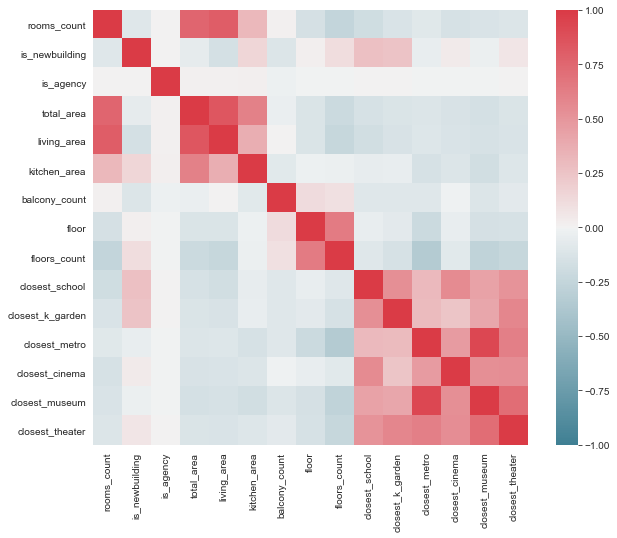

In [19]:
# Correlation matrix heatmap
f, ax = plt.subplots(figsize=(10, 8))
corr = X.corr()

sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            vmin = -1, square=True, ax=ax)

### Modeling

Настроим модель градиентного бустинга. Параметры выбраны на основе проведенного поиска по сетке. (поиск по сетке не включен в файл, ввиду тяжеловестности его проведения)

In [20]:
# Model SetUp with hyperparameters tuning (based on performed grid search)
cat_reg = CatBoostRegressor(iterations = 1500, 
                            learning_rate = 0.04, 
                            l2_leaf_reg = 4,  
                            depth = 7)

# Train/Test Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.25,
                                                    random_state = 42)

In [21]:
# Explicitly define categorical columns
cat_cols = ['street.name_ru', 'city.name_ru', 'rooms_count', 
            'released', 'is_newbuilding', 'is_agency', 'wc_type.title']

train_pool = Pool(X_train, y_train, cat_features = X[cat_cols])
test_pool = Pool(X_test, y_test, cat_features = X[cat_cols])

cat_reg.fit(train_pool, verbose = False)

In [22]:
# Evaluation
y_pred = cat_reg.predict(test_pool)

print('MAPE: {}, R^2: {}, RMSE: {}, MAE: {}'.format(mape(y_test, y_pred), 
                                                    r2_score(y_test, y_pred), 
                                                    np.sqrt(mse(y_test, y_pred)),
                                                    mae(y_test, y_pred)))

MAPE: 0.0941343091971395, R^2: 0.8242089317496858, RMSE: 25547.10663112829, MAE: 13414.43266040625


In [23]:
# Feature importances
feat_imp = dict(zip(X.columns, cat_reg.feature_importances_))
sorted_feature_imp = {k: v for k, v in sorted(feat_imp.items(), key=lambda item: item[1], reverse = True)}
sorted_feature_imp

{'total_area': 15.371795553878657,
 'closest_museum': 13.749985581255784,
 'floors_count': 12.369871047753765,
 'street.name_ru': 9.569090924576214,
 'kitchen_area': 6.044650824973466,
 'closest_k_garden': 5.593367746302499,
 'closest_metro': 5.590066986936254,
 'closest_theater': 5.310048750555737,
 'closest_cinema': 4.8475884817520285,
 'wc_type.title': 4.298342564314779,
 'rooms_count': 3.9688191224492377,
 'living_area': 3.500082016427281,
 'closest_school': 3.323502207784344,
 'floor': 3.3031199891211536,
 'is_newbuilding': 1.3606658622676184,
 'balcony_count': 0.9419866453107305,
 'city.name_ru': 0.8557016424488464,
 'released': 0.0009426020054287913,
 'is_agency': 0.0003714498863080587}

##### Таким образом, наша модель посчитала, что самым важным признаком образования величины цены за квадратный метр является:
* Общая площадь квартиры
* Близость к музею (что в теории является прокси к близости квартиры к исторической части города)
* Название улицы (что так же является маркером гегографического расположения квартиры)
* Дистанция до ближайшей станции метрополитена
* Площадь кухонной зоны
* Дистанции до ближайших детских садов, театров, кино
* Тип ванных и туалетных комнат

##### Графическое сравнение точности предсказания

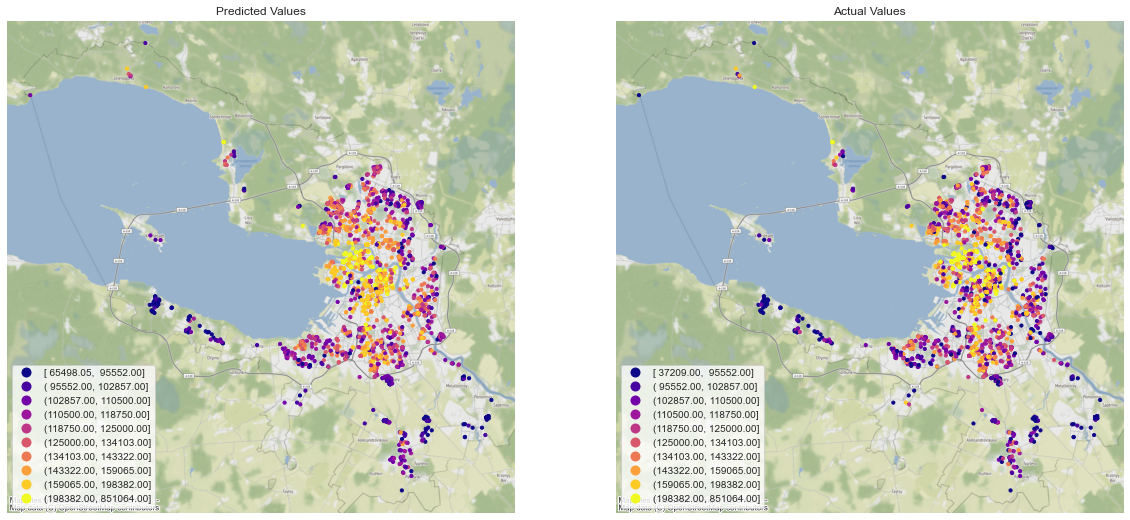

In [24]:
# Joining data based on its index (to append objects geometries)
geom = X_test.join(data['geometry'], lsuffix='', rsuffix='')
geom['prediction'] = cat_reg.predict(test_pool)
geom['y_true'] = y_test

# Creating unified scheme (quantiles based on y_true)
bins = mapclassify.Quantiles(geom['y_true'], k = 10).bins
classification_kwds = dict(bins = bins)

# Plotting Data 
fig, axs = plt.subplots(ncols = 2)
# Plotting apartments. Color based on its quantile (k=10)
gpd.GeoDataFrame(geom).plot(ax = axs[0],
                            column = 'prediction',
                            scheme ='user_defined',
                            classification_kwds = dict(bins = bins),
                            legend = True,
                            cmap = 'plasma',  
                            markersize = 10)

gpd.GeoDataFrame(geom).plot(ax = axs[1],
                            column = 'y_true', 
                            scheme = 'user_defined',
                            classification_kwds = dict(bins = bins),
                            legend = True,
                            cmap = 'plasma', 
                            markersize = 10)

# Adding layer with map 
contextily.add_basemap(axs[0])
contextily.add_basemap(axs[1])
axs[0].set_title('Predicted Values')
axs[1].set_title('Actual Values')
axs[0].set_axis_off()
axs[1].set_axis_off()
fig.set_figheight(20)
fig.set_figwidth(20)

plt.show()

* Как мы можем заметить из легенды графиков, наша модель плохо предсказывает крайне дешевые квартиры (в терминах цены за квадртаный метр) [в первый квантиль не включен ценовой диапазон от 37к до 56к]

* Так же заметна некоторая переоценка квартир на Васильевском острове, что может сведетельствовать о нехватке объясняющих переменных (есть в квартирах на Васильевском острове что-то такое, что делает их более дешевыми, чем предсказывает модель)  

##### Обучим финальную модель на всем доступном наборе данных, для увеличения ее предсказательной силы при валидации

In [25]:
# Fitting final model on all available data
fin_cat_reg = CatBoostRegressor(iterations = 1500, 
                                learning_rate = 0.04, 
                                l2_leaf_reg = 4,  
                                depth = 7)

fin_train_pool = Pool(X, y, cat_features = X[cat_cols])

fin_cat_reg.fit(fin_train_pool, verbose = False)

# VALIDATION 

In [34]:
# Write path to the test file
test_df = gpd.read_file(input())

 /Users/neteplo/Downloads/test-dataset.gpkg


In [41]:
test_df.shape

(886, 37)

In [36]:
# Data preprocessing
X_valid = auto_preprocess(test_df)

In [44]:
# Defining validation pool 
valid_pool = Pool(X_valid, cat_features = X_valid[cat_cols])

In [45]:
# Evaluation
y_pred = fin_cat_reg.predict(valid_pool)

#print('MAPE: {}, R^2: {}, RMSE: {}, MAE: {}'.format(mape(y_valid, y_pred), 
#                                                    r2_score(y_valid, y_pred), 
#                                                   np.sqrt(mse(y_valid, y_pred)),
#                                                   mae(y_valid, y_pred)))

In [67]:
test_df['price_per_sqm_predicted'] = y_pred

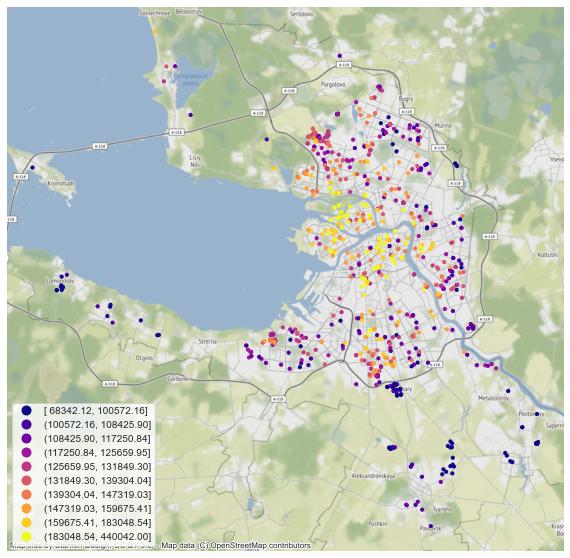

In [72]:
# Plotting Data 
fig, ax = plt.subplots(figsize = (10, 10))
# Plotting apartments. Color based on its quantile (k=10)
test_df.to_crs(3785).plot(ax = ax,
          column = 'price_per_sqm_predicted', 
          scheme = 'quantiles',
          k = 10, 
          cmap = 'plasma',  
          legend = True,
          markersize = 10)

# Adding layer with map 
contextily.add_basemap(ax)
ax.set_axis_off()
plt.savefig('pred.jpg', dpi=500)
plt.show()

Сравним результат графически

In [ ]:
# Joining data based on its index (to append objects geometries)
geom_valid = X_valid.join(test_df['geometry'], lsuffix='', rsuffix='')
geom_valid['prediction'] = y_pred
geom_valid['y_true'] = y_valid

# Creating unified scheme (quantiles based on y_true)
bins = mapclassify.Quantiles(geom['y_true'], k = 10).bins
classification_kwds = dict(bins = bins)

# Plotting Data 
fig, axs = plt.subplots(ncols = 2)
# Plotting apartments. Color based on its quantile (k=10)
gpd.GeoDataFrame(geom).plot(ax = axs[0],
                            column = 'prediction',
                            scheme = 'user_defined',
                            classification_kwds = dict(bins = bins),
                            legend = True,
                            cmap = 'plasma',  
                            markersize = 10)

gpd.GeoDataFrame(geom).plot(ax = axs[1],
                            column = 'y_true', 
                            scheme='user_defined',
                            classification_kwds = dict(bins = bins),
                            legend = True,
                            cmap = 'plasma', 
                            markersize = 10)

# Adding layer with map 
contextily.add_basemap(axs[0])
contextily.add_basemap(axs[1])
axs[0].set_title('Predicted Values')
axs[1].set_title('Actual Values')
axs[0].set_axis_off()
axs[1].set_axis_off()
fig.set_figheight(20)
fig.set_figwidth(20)

plt.show()